In [5]:
import numpy as np
from fuzzpy.fuzzpy.numbers import TriangularFuzzyNumber, TrapezoidalFuzzyNumber, FuzzyNumber
from fuzzpy.fuzzpy.structs import FuzzyNumberArray
from fuzzpy.fuzzpy.config import set_fuzzy_addition_method, get_fuzzy_addition_method

In [7]:
a = TriangularFuzzyNumber(0, 1, 2)
b = TrapezoidalFuzzyNumber(0, 1, 2, 3)
c = TriangularFuzzyNumber(1, 2, 3) + 5.0
v = FuzzyNumberArray([a, b, c])
d = FuzzyNumber(0, 1, 2, 3, left_fun=np.sin, right_fun=np.cos)

In [8]:
a * 2

TriangularFuzzyNumber(left=0.0, mid=2.0, right=4.0)

In [9]:
a * 3

TriangularFuzzyNumber(left=0.0, mid=3.0, right=6.0)

In [10]:
n = 10
cm = np.linspace(0, 10, n)
array = FuzzyNumberArray.random_triangular(n = n, c_mu= cm, c_sigma= 0.5, l1= 0.2, l2= 0.5, r1= 0.2, r2= 0.5)

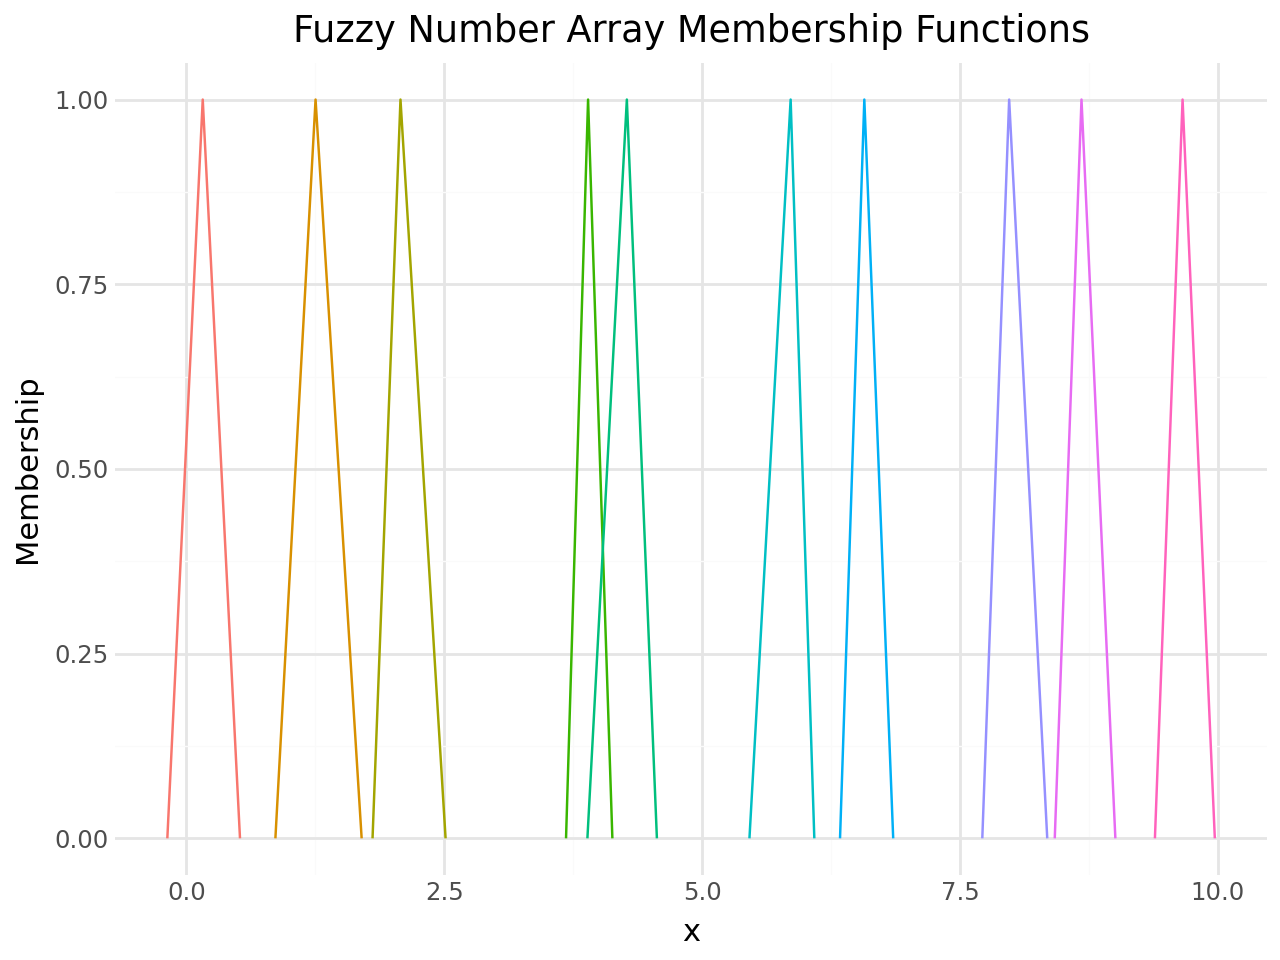

In [11]:
array.plot()

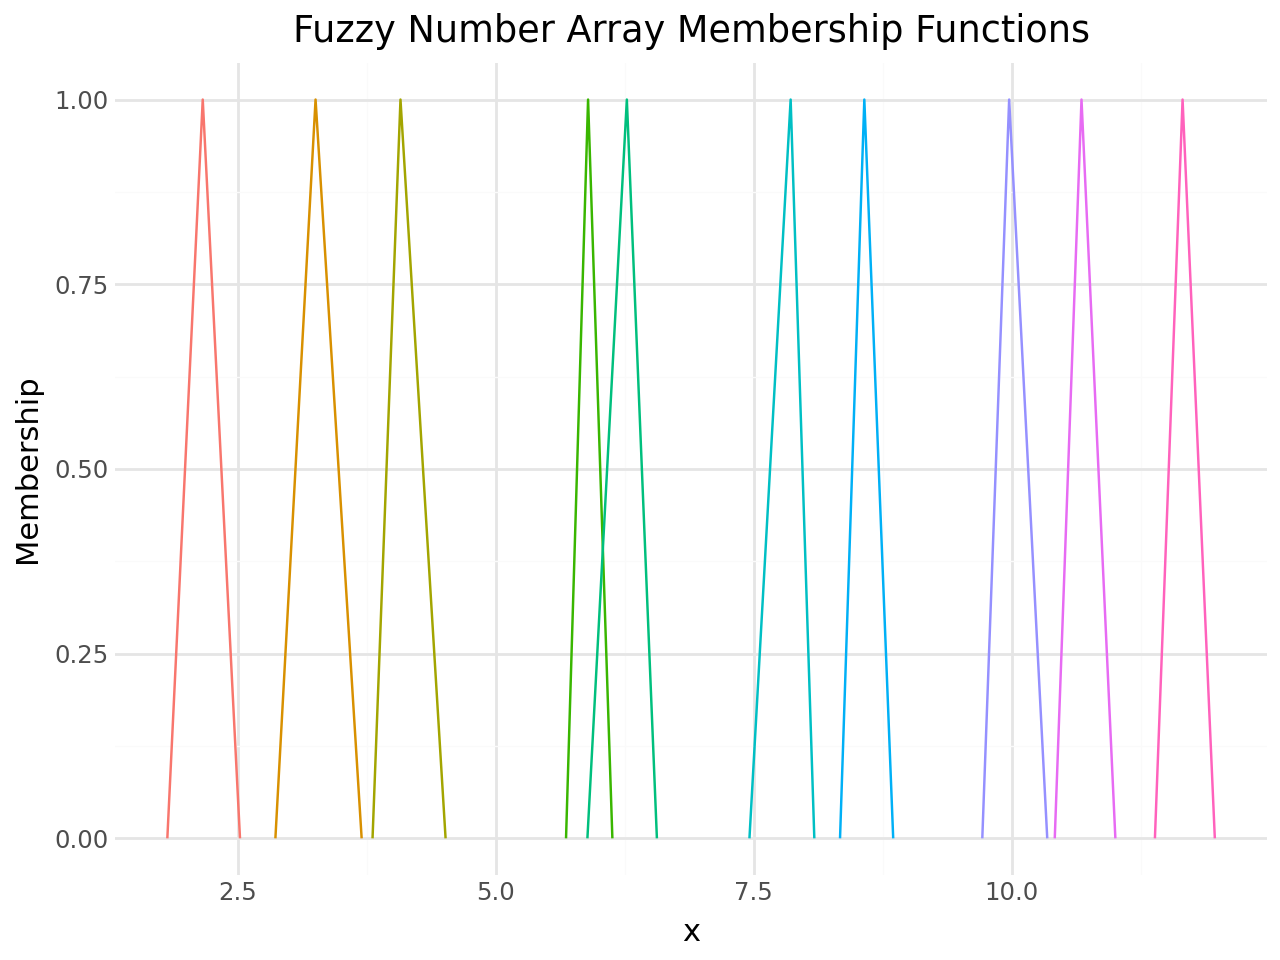

In [12]:
(array + 2).plot()

In [13]:
c

TriangularFuzzyNumber(left=6.0, mid=7.0, right=8.0)

In [14]:
array.mid

array([0.15804386, 1.251738  , 2.07493191, 3.89349654, 4.26935998,
       5.85722324, 6.57148883, 7.97553243, 8.67680475, 9.65664466])

In [ ]:
def ICr_alpha(vector: FuzzyNumberArray[TriangularFuzzyNumber], alpha: float = 0.5) -> np.array:
    if alpha < 0.5:
        res = 2 * (vector.mids - vector.a) * alpha + vector.left
    else:
        res = 2 * (vector.right - vector.mid) * alpha + 2 * vector.mid - vector.right
    return res

In [3]:
import numpy as np
import pandas as pd

def generate_TFN(mu, sigma, l1, l2, r1, r2, n=1, random_state=None):
    rng = np.random.default_rng(random_state)
    c = rng.normal(mu, sigma, n)
    l = rng.uniform(l1, l2, n)
    r = rng.uniform(r1, r2, n)
    # TriangularFuzzyNumber(c-l, c, c+r)
    return [TriangularFuzzyNumber(c_i - l_i, c_i, c_i + r_i) for c_i, l_i, r_i in zip(c, l, r)]

def ICr_alpha(TFN, alpha):
    a = np.array([x.left for x in TFN])
    b = np.array([x.mid for x in TFN])
    c = np.array([x.right for x in TFN])
    if alpha < 0.5:
        res = 2 * (b - a) * alpha + a
    else:
        res = 2 * (c - b) * alpha + 2 * b - c
    return res

def T_statistic(X, Y, by_alpha):
    N_X = len(X)
    N_Y = len(Y)
    alphas = np.arange(0, 1 + by_alpha, by_alpha)
    x_icr = [ICr_alpha(X, a) for a in alphas]
    y_icr = [ICr_alpha(Y, a) for a in alphas]
    xicr_mean = [np.mean(x) for x in x_icr]
    yicr_mean = [np.mean(y) for y in y_icr]
    xicr_var = [np.var(x, ddof=1) for x in x_icr]
    yicr_var = [np.var(y, ddof=1) for y in y_icr]
    numerator = np.abs(np.array(xicr_mean) - np.array(yicr_mean))
    denominator = np.sqrt(np.array(xicr_var) / N_X + np.array(yicr_var) / N_Y)
    ratio = numerator / denominator
    t = np.nanmax(ratio)
    return t

def ICr_test(X, Y, by_alpha, no_perm, random_state=None):
    rng = np.random.default_rng(random_state)
    t0 = T_statistic(X, Y, by_alpha)
    XY = [*X, *Y]
    N_X = len(X)
    N_XY = len(XY)
    perms = np.array([rng.permutation(N_XY) for _ in range(no_perm)])
    t_perm = []
    for row in perms:
        X_perm = [XY[i] for i in row[:N_X]]
        Y_perm = [XY[i] for i in row[N_X:]]
        t_perm.append(T_statistic(X_perm, Y_perm, by_alpha))
    t_perm = np.array(t_perm)
    pval = np.mean(t_perm >= t0)
    return pval

def ICr_test_mu_samples(mu_X, mu_Y, n_TFN, samples, by_alpha, no_perm, random_state=None):
    rng = np.random.default_rng(random_state)
    X_list = [generate_TFN(mu_X, 1, 0, 0.5, 0, 0.5, n_TFN, rng) for _ in range(samples)]
    Y_list = [generate_TFN(mu_Y, 1, 0, 0.5, 0, 0.5, n_TFN, rng) for _ in range(samples)]
    pvals = [ICr_test(X, Y, by_alpha, no_perm, rng) for X, Y in zip(X_list, Y_list)]
    res = np.mean(np.array(pvals) < 0.05)
    return res


In [ ]:
set_fuzzy_addition_method("extension_principle")

In [4]:
import numpy as np
import pandas as pd

def generate_TFN(mu, sigma, l1, l2, r1, r2, n=1, random_state=None):
    rng = np.random.default_rng(random_state)
    c = rng.normal(mu, sigma, n)
    l = rng.uniform(l1, l2, n)
    r = rng.uniform(r1, r2, n)
    # TriangularFuzzyNumber(c-l, c, c+r)
    return [TriangularFuzzyNumber(c_i - l_i, c_i, c_i + r_i) for c_i, l_i, r_i in zip(c, l, r)]

def ICr_alpha_slow(TFN: list[TriangularFuzzyNumber], alpha: float) -> list[float]:
    if alpha < 0.5:
        res = 2 * (TFN.mid - TFN.left) * alpha + TFN.left
    else:
        res = 2 * (TFN.right - TFN.mid) * alpha + 2 * TFN.mid - TFN.right


In [5]:
X = generate_TFN(mu=2, sigma=0.5, l1=0.2, l2=0.5, r1=0.2, r2=0.5, n=3000, random_state=42)
Y = generate_TFN(mu=3, sigma=0.5, l1=0.2, l2=0.5, r1=0.2, r2=0.5, n=30, random_state=43)

In [6]:
fuzzyArray = FuzzyNumberArray(X)

In [16]:
np.array([x.left for x in X])

array([1.73442065, 1.18663066, 1.9803456 , ..., 1.31787766, 1.79267678,
       1.92772738], shape=(300000,))

In [33]:
import time

start = time.time()
ICr_alpha_slow(fuzzyArray, 0.1)
end = time.time()
print(f"Elapsed time: {end - start:.3f} seconds")
start = time.time()
a_X = np.array([y.left for y in X])
b_X = np.array([y.mid for y in X])
c_X = np.array([y.right for y in X])
ICr_alpha_numba(a_X, b_X, c_X, 0.1)
end = time.time()
print(f"Elapsed time: {end - start:.3f} seconds")

Elapsed time: 0.142 seconds
Elapsed time: 0.121 seconds


In [55]:
import time

start = time.time()
# Generate two samples of Triangular Fuzzy Numbers
X = generate_TFN(mu=2, sigma=0.5, l1=0.2, l2=0.5, r1=0.2, r2=0.5, n=300, random_state=42)
Y = generate_TFN(mu=3, sigma=0.5, l1=0.2, l2=0.5, r1=0.2, r2=0.5, n=300, random_state=43)

# Run the ICr_test between X and Y
pval = ICr_test(X, Y, by_alpha=0.1, no_perm=100, random_state=44)
print(f"ICr_test p-value: {pval}")

# Run the ICr_test_mu_samples to estimate power
power = ICr_test_mu_samples(mu_X=2, mu_Y=3, n_TFN=300, samples=10, by_alpha=0.1, no_perm=100, random_state=45)
print(f"Estimated power (proportion of p < 0.05): {power}")
end = time.time()
print(f"Elapsed time: {end - start:.3f} seconds")

ICr_test p-value: 0.0
Estimated power (proportion of p < 0.05): 1.0
Elapsed time: 17.383 seconds


In [20]:
from numba import njit

def generate_TFN(mu, sigma, l1, l2, r1, r2, n=1, random_state=None):
    rng = np.random.default_rng(random_state)
    c = rng.normal(mu, sigma, n)
    l = rng.uniform(l1, l2, n)
    r = rng.uniform(r1, r2, n)
    # TriangularFuzzyNumber(c-l, c, c+r)
    return pd.DataFrame({
        'A': c - l,
        'B': c,
        'C': c + r
    })

@njit
def ICr_alpha_numba(a, b, c, alpha):
    res = np.empty_like(a)
    for i in range(a.shape[0]):
        if alpha < 0.5:
            res[i] = 2 * (b[i] - a[i]) * alpha + a[i]
        else:
            res[i] = 2 * (c[i] - b[i]) * alpha + 2 * b[i] - c[i]
    return res

def T_statistic_numba(X, Y, by_alpha):
    N_X = len(X)
    N_Y = len(Y)
    alphas = np.arange(0, 1 + by_alpha, by_alpha)
    a_X = X.iloc[:, 0].values
    b_X = X.iloc[:, 1].values
    c_X = X.iloc[:, 2].values
    a_Y = Y.iloc[:, 0].values
    b_Y = Y.iloc[:, 1].values
    c_Y = Y.iloc[:, 2].values
    xicr_mean = []
    yicr_mean = []
    xicr_var = []
    yicr_var = []
    for alpha in alphas:
        x_icr = ICr_alpha_numba(a_X, b_X, c_X, alpha)
        y_icr = ICr_alpha_numba(a_Y, b_Y, c_Y, alpha)
        xicr_mean.append(np.mean(x_icr))
        yicr_mean.append(np.mean(y_icr))
        xicr_var.append(np.var(x_icr, ddof=1))
        yicr_var.append(np.var(y_icr, ddof=1))
    numerator = np.abs(np.array(xicr_mean) - np.array(yicr_mean))
    denominator = np.sqrt(np.array(xicr_var) / N_X + np.array(yicr_var) / N_Y)
    ratio = numerator / denominator
    t = np.nanmax(ratio)
    return t

def ICr_test_numba(X, Y, by_alpha, no_perm, random_state=None):
    rng = np.random.default_rng(random_state)
    t0 = T_statistic_numba(X, Y, by_alpha)
    XY = pd.concat([X, Y], ignore_index=True)
    N_X = len(X)
    N_XY = len(XY)
    perms = np.array([rng.permutation(N_XY) for _ in range(no_perm)])
    t_perm = []
    for row in perms:
        X_perm = XY.iloc[row[:N_X]].reset_index(drop=True)
        Y_perm = XY.iloc[row[N_X:]].reset_index(drop=True)
        t_perm.append(T_statistic_numba(X_perm, Y_perm, by_alpha))
    t_perm = np.array(t_perm)
    pval = np.mean(t_perm >= t0)
    return pval

def ICr_test_mu_samples_numba(mu_X, mu_Y, n_TFN, samples, by_alpha, no_perm, random_state=None):
    rng = np.random.default_rng(random_state)
    X_list = [generate_TFN(mu_X, 1, 0, 0.5, 0, 0.5, n_TFN, rng) for _ in range(samples)]
    Y_list = [generate_TFN(mu_Y, 1, 0, 0.5, 0, 0.5, n_TFN, rng) for _ in range(samples)]
    pvals = [ICr_test_numba(X, Y, by_alpha, no_perm, rng) for X, Y in zip(X_list, Y_list)]
    res = np.mean(np.array(pvals) < 0.05)
    return res

In [57]:
X = generate_TFN(mu=2, sigma=0.5, l1=0.2, l2=0.5, r1=0.2, r2=0.5, n=300, random_state=42)
Y = generate_TFN(mu=3, sigma=0.5, l1=0.2, l2=0.5, r1=0.2, r2=0.5, n=300, random_state=43)
start = time.time()
# Run the numba-accelerated ICr_test between X and Y
pval_numba = ICr_test_numba(X, Y, by_alpha=0.1, no_perm=100, random_state=44)
print(f"ICr_test_numba p-value: {pval_numba}")

# Run the numba-accelerated ICr_test_mu_samples to estimate power
power_numba = ICr_test_mu_samples_numba(mu_X=2, mu_Y=3, n_TFN=300, samples=10, by_alpha=0.1, no_perm=100, random_state=45)
print(f"Estimated power (numba, proportion of p < 0.05): {power_numba}")
end = time.time()
print(f"Elapsed time (numba): {end - start:.3f} seconds")

ICr_test_numba p-value: 0.0
Estimated power (numba, proportion of p < 0.05): 1.0
Elapsed time (numba): 1.856 seconds


In [5]:
class ClassWithMethod:
    def __init__(self, value):
        self.value = value
        self.__hidden = "This is a hidden attribute"

    def method(self, other):
        if isinstance(other, ClassWithMethod):
            return self.value + other.value
        else:
            return NotImplemented

In [9]:
c = ClassWithMethod(10)
c._ClassWithMethod__hidden

'This is a hidden attribute'